In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

In [2]:
df=pd.read_csv('adhdata.csv')
print('dataset shape',df.shape)
print('columns',df.columns)

dataset shape (2166383, 21)
columns Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')


In [3]:
# Encoding the class labels 
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD -> 1, Control -> 0
X = df.drop(['Class', 'ID'], axis=1).values
y = df['Class'].values

# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
sample_fraction = 0.1  
df_sampled = df.sample(frac=sample_fraction, random_state=42)

# Re-prepare X and y from the sampled dataframe
X_sampled = df_sampled.drop(['Class', 'ID'], axis=1).values
y_sampled = df_sampled['Class'].values

# Scale features
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled_scaled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

In [4]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7082256277695717
              precision    recall  f1-score   support

        ADHD       0.70      0.84      0.76     24164
     Control       0.73      0.54      0.62     19164

    accuracy                           0.71     43328
   macro avg       0.71      0.69      0.69     43328
weighted avg       0.71      0.71      0.70     43328



In [8]:
# Step 1: Encode the full dataset labels first
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # Converts 'Control'/'ADHD' to 0/1

# Step 2: Sample 10% data from this fully encoded dataset
sample_fraction = 0.1  
df_sampled = df.sample(frac=sample_fraction, random_state=42)

# Step 3: Prepare X and y from the sampled dataset
X_sampled = df_sampled.drop(['Class', 'ID'], axis=1).values
y_sampled = df_sampled['Class'].values  # This should now be numeric

# Step 4: Scale features
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)

# Step 5: Train-test split with stratify to maintain label ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled_scaled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

# Step 6: Reshape inputs for CNN+LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_cnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 7: One-hot encode labels (they should be integers now)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Step 8: Build model
model = Sequential()
model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Step 9: Train model
history = model.fit(X_train_cnn, y_train_cat, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

C:\Users\deeks\anaconda3\envs\eeg_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,434 (134.51 KB)

 Trainable params: 34,434 (134.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.6721 - loss: 0.6071 - val_accuracy: 0.7462 - val_loss: 0.5248
Epoch 2/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7449 - loss: 0.5260 - val_accuracy: 0.7565 - val_loss: 0.5077
Epoch 3/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7528 - loss: 0.5133 - val_accuracy: 0.7536 - val_loss: 0.5084
Epoch 4/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7576 - loss: 0.5034 - val_accuracy: 0.7603 - val_loss: 0.4996
Epoch 5/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7593 - loss: 0.5015 - val_accuracy: 0.7638 - val_loss: 0.4951
Epoch 6/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7624 - loss: 0.4958 - val_accuracy: 0.7627 - val_loss: 0.4949
Epoch 7/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7660 - loss: 0.4912 - val_accuracy: 0.7644 - val_loss: 0.4886
Epoch 8/15
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.7660 - loss: 0

1354/1354 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7797 - loss: 0.4649
CNN-LSTM Test Accuracy: 0.7801
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


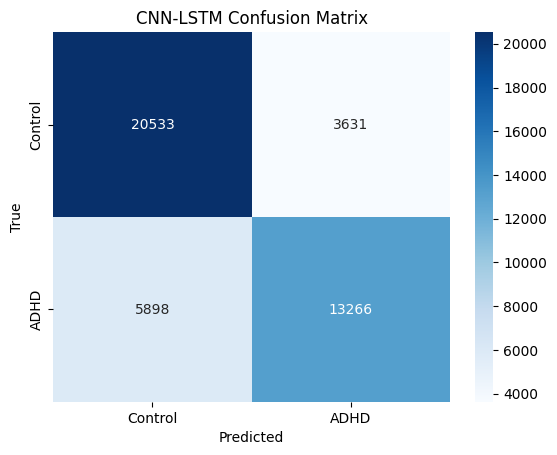

              precision    recall  f1-score   support

           0       0.78      0.85      0.81     24164
           1       0.79      0.69      0.74     19164

    accuracy                           0.78     43328
   macro avg       0.78      0.77      0.77     43328
weighted avg       0.78      0.78      0.78     43328



In [9]:
loss, acc = model.evaluate(X_test_cnn, y_test_cat)
print(f"CNN-LSTM Test Accuracy: {acc:.4f}")

# Confusion Matrix
y_pred_dl = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_dl, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "ADHD"], yticklabels=["Control", "ADHD"])
plt.title("CNN-LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))

In [10]:
model.save("adhd_eeg_model.h5")